# Colocalization permutation

In [1]:
# Load libraries
import sys, os
import numpy as np
import pandas as pd
from copy import copy, deepcopy
from tqdm import tqdm
import random
import math
import scanpy as sc

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Load starmap python library 
from starmap.sequencing import *

In [22]:
# IO path
fpath = '/stanley/WangLab/Data/Analyzed/2022-02-02-Hu-Hela_FUCCI'
rpath = '/stanley/WangLab/Connie/01.RIBOmap/result/FUCCI data'
result_path = '/stanley/WangLab/Connie/01.RIBOmap/result/revision/discrete_bulk'
sample = 'starmap'

# Input

In [3]:
# adata
adata = sc.read_h5ad(rpath+'/adata/FUCCI_{}_cc_02-22-22.h5ad'.format(sample))

In [4]:
# genes
genes = adata.var.index
n_genes = len(genes)

In [5]:
# points, bases
genes2seqs, seqs2genes = load_genes(fpath)
mat_bases, mat_points = load_reads_3D(os.path.join(fpath, 'merged_spots', sample), 'merged_goodPoints_max3d.mat')
points = mat_points.astype(int)
bases = np.array([seqs2genes[x] for x in mat_bases])
points_real = np.concatenate(((points[:,0]/30*10.2735).reshape(points.shape[0],1), points[:,1:]/3072*290.7187), axis=1)

Number of reads: 4682360


In [6]:
# reads to cell
rtc = np.load('rtc_STAR.npy')

In [7]:
# filter cells
cells_flt = adata.obs[adata.obs['pass_all_filters']]['orig_index'].values+1
rtc_flt = rtc[np.isin(rtc, adata.obs[adata.obs['pass_all_filters']]['orig_index']+1)]
points_real_flt = points_real[np.isin(rtc, adata.obs[adata.obs['pass_all_filters']]['orig_index']+1)]
bases_flt = bases[np.isin(rtc, adata.obs[adata.obs['pass_all_filters']]['orig_index']+1)]

# Main

## check shape of permutation distribution for a single gene-pair

In [ ]:
test_size = 500
test_cells = np.random.choice(cells_flt, size=test_size, replace=False)

In [26]:
def save_each_perm(points, bases, n_genes, rad=1.5, n_perm=1):
    count = np.zeros((n_genes, n_genes))
    perm = np.zeros((n_perm, n_genes, n_genes))
    
    # run rnn
    rnn = NearestNeighbors(radius=rad)
    rnn.fit(points)
    I = rnn.radius_neighbors(return_distance=False)

    # observed counts
    for i, nbrs in enumerate(I):
        curr_cell = rtc[i]
        nbrs = nbrs[rtc[nbrs] == curr_cell]
        for nbr in nbrs:
            count[bases[i], bases[nbr]] += 1

    # permutation
    shuffle_bs = deepcopy(bases)
    for p in tqdm(range(n_perm)):
        np.random.shuffle(shuffle_bs)
        for i, nbrs in enumerate(I):
            curr_cell = rtc[i]
            nbrs = nbrs[rtc[nbrs] == curr_cell]
            for nbr in nbrs:
                perm[p, shuffle_bs[i], shuffle_bs[nbr]] += 1
    return count, perm

In [94]:
test_points = points_real_flt[np.isin(rtc_flt, test_cells)]
test_bases = bases_flt[np.isin(rtc_flt, test_cells)]
genes_ = list(genes)
test_bases_ind = np.array([genes_.index(g) for g in test_bases])

### radus = 1.5

In [95]:
radius = 1.5
count, perm = save_each_perm(test_points, test_bases_ind, n_genes, rad=radius, n_perm=10000)

100%|██████████| 10000/10000 [17:54:52<00:00,  6.45s/it] 


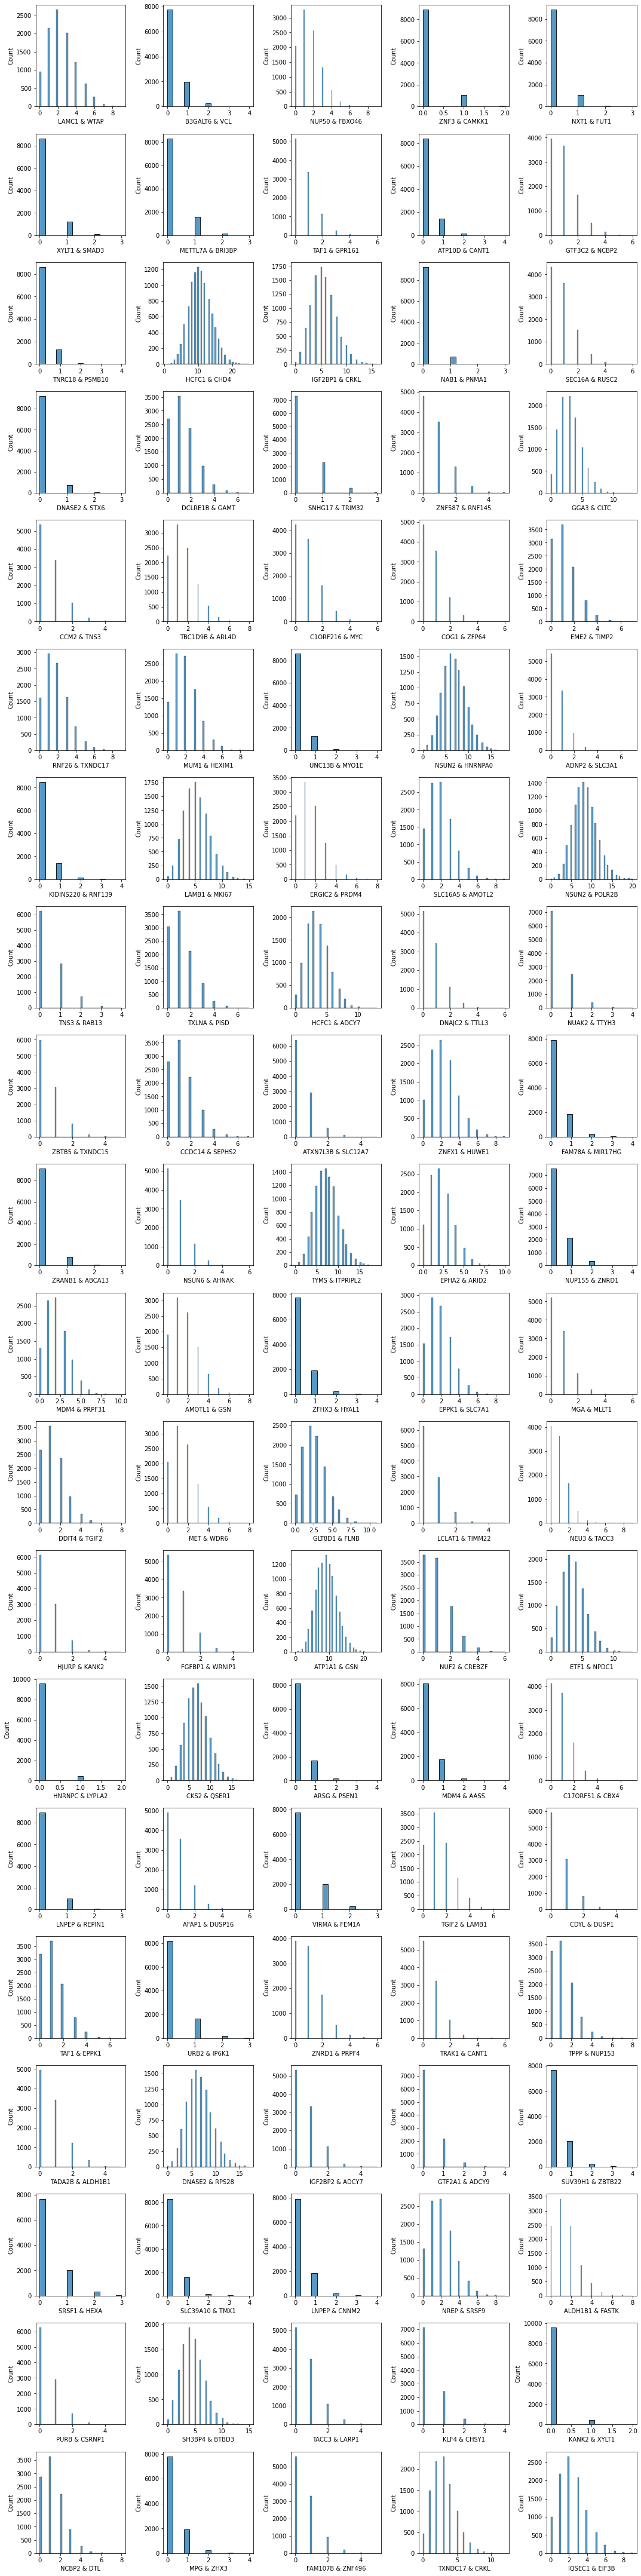

In [96]:
# randomly choose 100 pairs
n_pairs = 100
n_fig_per_row = 5
fig, ax = plt.subplots(math.ceil(n_pairs/n_fig_per_row), n_fig_per_row, figsize=(3*n_fig_per_row, 3*math.ceil(n_pairs/n_fig_per_row)))
for pair in range(n_pairs):
    g1 = random.choice(range(n_genes))
    g2 = random.choice(range(n_genes))
    sns.histplot(perm[:,g1,g2], ax=ax[pair//5, pair-pair//5*5]).set_xlabel(f'{genes[g1]} & {genes[g2]}')
plt.tight_layout()

### radius = 2

In [60]:
radius = 2
count1, perm1 = save_each_perm(test_points, test_bases_ind, n_genes, rad=radius, n_perm=1000)

100%|██████████| 1000/1000 [25:52<00:00,  1.55s/it]


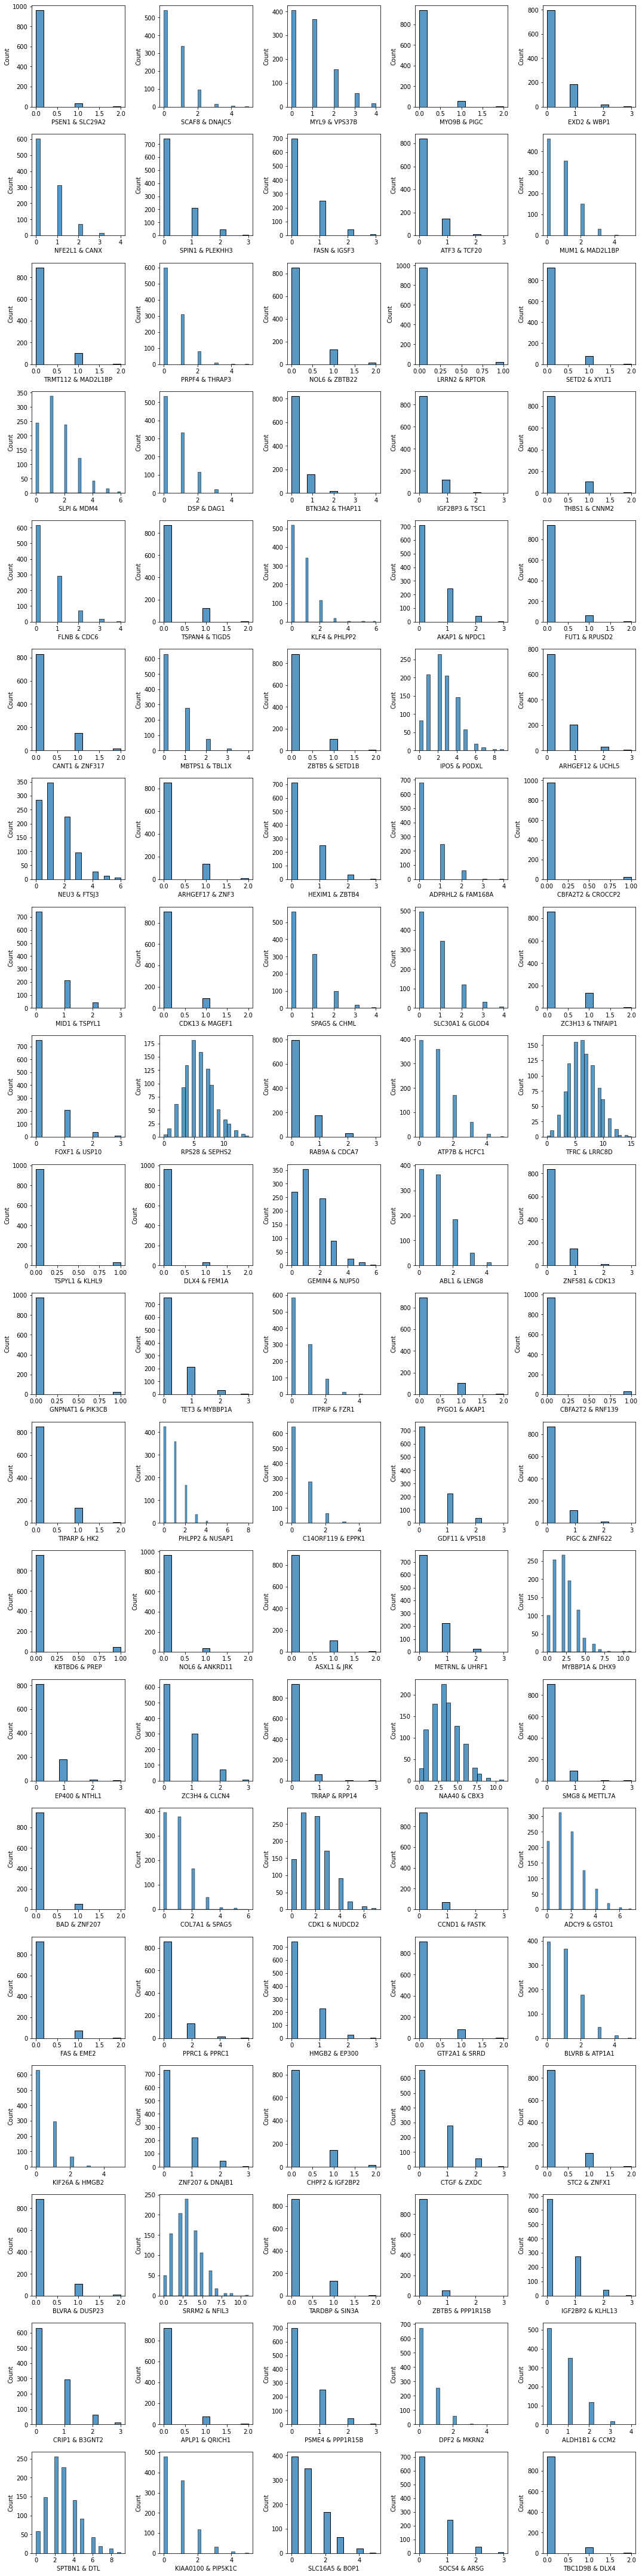

In [61]:
n_pairs = 100
n_fig_per_row = 5
fig, ax = plt.subplots(math.ceil(n_pairs/n_fig_per_row), n_fig_per_row, figsize=(3*n_fig_per_row, 3*math.ceil(n_pairs/n_fig_per_row)))
for pair in range(n_pairs):
    g1 = random.choice(range(n_genes))
    g2 = random.choice(range(n_genes))
    sns.histplot(perm1[:,g1,g2], ax=ax[pair//5, pair-pair//5*5]).set_xlabel(f'{genes[g1]} & {genes[g2]}')
plt.tight_layout()

## result

### radius = 1.5

In [7]:
samples = ['starmap', 'ribomap']
data = ['count', 'p_values', 'perm_mean']

1. r=1.5 test=300 n_perm=1000

In [41]:
radius = 1.5
test_size = 300
n_perm = 1000

r1 = dict()
for s in samples:
    r1[s] = dict()
    for d in data:
        r1[s][d] = np.load(os.path.join(result_path, 
                                        f'r{radius}_test{test_size}_perm{n_perm}',
                                        'count_pval_perm', 
                                        f'{d}_{s}_r{radius}_test{test_size}_perm{n_perm}.npy'))

In [4]:
# quick-look
# sns.clustermap(r1['starmap']['count'], figsize=(5,5))
# sns.clustermap(r1['ribomap']['count'], figsize=(5,5))
# sns.clustermap(r1['starmap']['p_values'], figsize=(5,5))
# sns.clustermap(r1['ribomap']['p_values'], figsize=(5,5))
# sns.clustermap(r1['starmap']['perm_mean'], figsize=(5,5))
# sns.clustermap(r1['ribomap']['perm_mean'], figsize=(5,5))

In [47]:
# log2FC
sample = 'ribomap'
r1[sample]['logfc'] = np.log2(r1[sample]['count'] / r1[sample]['perm_mean'] + 1) # NOTE contains both nan and inf (nan because 0/0, inf because pos/0)

/local/scratch/34327784.1.interactive/ipykernel_18102/660440769.py:3: RuntimeWarning:

divide by zero encountered in true_divide

/local/scratch/34327784.1.interactive/ipykernel_18102/660440769.py:3: RuntimeWarning:

invalid value encountered in true_divide



In [48]:
# check nan and inf
# np.count_nonzero(np.isnan())
r1[sample]['logfc'][np.where(np.isnan(r1[sample]['logfc']))] = 1 # np.log2(1+1) = 1 (take 0/0=1)

In [49]:
r1[sample]['logfc'][np.where(np.isinf(r1[sample]['logfc']))] = np.NINF
r1[sample]['logfc'][np.where(np.isinf(r1[sample]['logfc']))] = np.nanmax(r1[sample]['logfc']) 

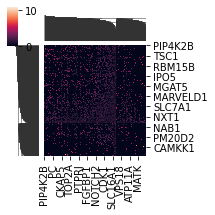

In [50]:
# clustering on log2FC
g = sns.clustermap(pd.DataFrame(r1[sample]['logfc'], columns=genes, index=genes), figsize=(3,3))
# format for plotly
order = np.array(g.dendrogram_col.reordered_ind)
temp = r1[sample]['logfc'][order]
logfc_reorder = temp[:,order]
genes_reorder = genes[order]

fig = px.imshow(logfc_reorder, x=genes_reorder, y=genes_reorder)
fig.write_html(os.path.join(result_path, 
                            f'r{radius}_test{test_size}_perm{n_perm}',
                            sample, 
                            f'{d}_{s}_r{radius}_test{test_size}_perm{n_perm}_log2fc.html'))
pd.DataFrame(genes_reorder).to_excel(os.path.join(result_path, 
                                    f'r{radius}_test{test_size}_perm{n_perm}',
                                    sample, 
                                    f'genes_ro_{sample}.xlsx'), 
                                    sheet_name=f'r{radius}_test{test_size}_perm{n_perm}')

In [51]:
# volcano
df = pd.DataFrame(zip(np.repeat(genes, n_genes), np.tile(genes, n_genes), r1[sample]['logfc'].flatten(), -np.log10(r1[sample]['p_values']+1).flatten()), columns=['gene1', 'gene2', 'log2fc', '-log10pval'])
fig_ = px.scatter(df, x='log2fc', y='-log10pval', hover_data=['gene1', 'gene2'])
fig_.write_html(os.path.join(result_path, 
                            f'r{radius}_test{test_size}_perm{n_perm}',
                            sample, 
                            f'{d}_{s}_r{radius}_test{test_size}_perm{n_perm}_volcano.html'))

3. r=1.5 test=300 n_perm=10000

In [53]:
radius = 1.5
test_size = 500
n_perm = 10000

r3 = dict()
for s in samples:
    r3[s] = dict()
    for d in data:
        r3[s][d] = np.load(os.path.join(result_path, 
                                        f'r{radius}_test{test_size}_perm{n_perm}',
                                        'count_pval_perm', 
                                        f'{d}_{s}_r{radius}_test{test_size}_perm{n_perm}.npy'))

In [12]:
# quick-look
# sns.clustermap(r3['starmap']['count'], figsize=(5,5))
# sns.clustermap(r3['ribomap']['count'], figsize=(5,5))
# sns.clustermap(r3['starmap']['p_values'], figsize=(5,5))
# sns.clustermap(r3['ribomap']['p_values'], figsize=(5,5))
# sns.clustermap(r3['starmap']['perm_mean'], figsize=(5,5))
# sns.clustermap(r3['ribomap']['perm_mean'], figsize=(5,5))

In [58]:
# log2FC
sample = 'ribomap'
r3[sample]['logfc'] = np.log2(r3[sample]['count'] / r3[sample]['perm_mean'] + 1) # NOTE contains both nan and inf (nan because 0/0, inf because pos/0)

In [59]:
np.count_nonzero(np.isinf(r3[sample]['logfc'])), np.count_nonzero(np.isnan(r3[sample]['logfc']))

(0, 0)

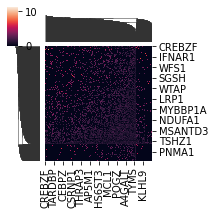

In [60]:
# clustering on log2FC
g = sns.clustermap(pd.DataFrame(r3[sample]['logfc'], columns=genes, index=genes), figsize=(3,3))
# format for plotly
order = np.array(g.dendrogram_col.reordered_ind)
temp = r3[sample]['logfc'][order]
logfc_reorder = temp[:,order]
genes_reorder = genes[order]

fig = px.imshow(logfc_reorder, x=genes_reorder, y=genes_reorder)
fig.write_html(os.path.join(result_path, 
                            f'r{radius}_test{test_size}_perm{n_perm}',
                            sample, 
                            f'{d}_{s}_r{radius}_test{test_size}_perm{n_perm}_log2fc.html'))
pd.DataFrame(genes_reorder).to_excel(os.path.join(result_path, 
                                    f'r{radius}_test{test_size}_perm{n_perm}',
                                    sample, 
                                    f'genes_ro_{sample}.xlsx'), 
                                    sheet_name=f'r{radius}_test{test_size}_perm{n_perm}')

In [61]:
# volcano
df = pd.DataFrame(zip(np.repeat(genes, n_genes), np.tile(genes, n_genes), r3[sample]['logfc'].flatten(), -np.log10(r3[sample]['p_values']+1).flatten()), columns=['gene1', 'gene2', 'log2fc', '-log10pval'])
fig_ = px.scatter(df, x='log2fc', y='-log10pval', hover_data=['gene1', 'gene2'])
fig_.write_html(os.path.join(result_path, 
                            f'r{radius}_test{test_size}_perm{n_perm}',
                            sample, 
                            f'{d}_{s}_r{radius}_test{test_size}_perm{n_perm}_volcano.html'))